# Introduction

A short notebook where we explore hair removal techniques on dermatoscopic images

## Import libraries

In [2]:
# Basic libraries
import os
import warnings
import cv2
from tqdm import tqdm 
import random


import matplotlib.pyplot as plt

## Load data

In [3]:
# from google.colab import drive
# drive.mount("/content/gdrive")

In [4]:
INPUT_FOLDER = "/Users/user/Desktop/MunjeLumenDS2025/data/sample_images/jpg/"
OUTPUT_FOLDER = "/Users/user/Desktop/MunjeLumenDS2025/data/sample_images/cleaned/"
RESIZED_FOLDER = "/Users/user/Desktop/MunjeLumenDS2025/data/sample_images/resized/"

In [5]:
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(RESIZED_FOLDER, exist_ok=True)

# Util functions

In [6]:
def resize_and_save_images(input_folder, resized_folder, image_size=(256, 256)):
    """
    Resize images and save them in a separate folder.
    """
    os.makedirs(resized_folder, exist_ok=True)  # Ensure resized folder exists
    file_list = os.listdir(input_folder)  # Get all files in the folder

    for file_name in tqdm(file_list, desc="Resizing Images", unit="file"):
        image_path = os.path.join(input_folder, file_name)
        image = cv2.imread(image_path)

        if image is None:
            continue

        # Resize image
        resized_image = cv2.resize(image, image_size, interpolation=cv2.INTER_AREA)

        # Save resized image
        resized_path = os.path.join(resized_folder, file_name)
        cv2.imwrite(resized_path, resized_image)

    print("✅ Resizing Complete! Resized images saved in:", resized_folder)


In [7]:
def show_images_in_line(folder_path, num_images=5, image_width=100, image_height=100):
    """
    Displays images from a folder in a single row using Matplotlib.

    :param folder_path: Path to the folder containing images.
    :param num_images: Number of images to display.
    :param image_width: Width to resize each image.
    :param image_height: Height to resize each image.
    """
    # Get list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    
    # Limit to the desired number of images
    image_files = image_files[:num_images]

    if not image_files:
        print("No images found in the folder.")
        return

    fig, axes = plt.subplots(1, len(image_files), figsize=(len(image_files) * 3, 3))

    # If only one image, make axes a list for uniformity
    if len(image_files) == 1:
        axes = [axes]

    for ax, file in zip(axes, image_files):
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path)  # Read image with OpenCV
        if img is None:
            continue  # Skip unreadable images
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib
        img = cv2.resize(img, (image_width, image_height))  # Resize for consistency
        ax.imshow(img)
        ax.set_title(file)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# SharpRazor

## Defining functions

In [8]:
def apply_clahe(image):
    """Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) for low-contrast images."""
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    enhanced_image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return enhanced_image


In [9]:
def detect_hair(image):
    """Detect hair using adaptive thresholding and morphological operations."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Black-Hat Morphological Operation to highlight hair
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))  # Adjust for different hair thickness
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    
    # Adaptive thresholding to create hair mask
    _, hair_mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Use morphology to refine the hair mask (remove noise)
    kernel_refine = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    hair_mask = cv2.morphologyEx(hair_mask, cv2.MORPH_CLOSE, kernel_refine, iterations=2)

    return hair_mask



In [10]:
def remove_hair(image, hair_mask):
    """Remove hair by inpainting detected areas using Navier-Stokes inpainting."""
    result = cv2.inpaint(image, hair_mask, inpaintRadius=5, flags=cv2.INPAINT_NS)
    return result


In [11]:
def process_folder(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists
    file_list = os.listdir(input_folder)  # Get all files in the folder

    for file_name in tqdm(file_list, desc="Processing Images", unit="file"):
        image_path = os.path.join(input_folder, file_name)
        image = cv2.imread(image_path)

        if image is None:
            continue

        # Process the resized image
        enhanced_image = apply_clahe(image)
        hair_mask = detect_hair(enhanced_image)
        clean_image = remove_hair(image, hair_mask)

        output_path = os.path.join(output_folder, file_name)
        cv2.imwrite(output_path, clean_image)  # Save processed image

    print("✅ Batch Processing Complete!")



## Processing

In [12]:
resize_and_save_images(INPUT_FOLDER, RESIZED_FOLDER, (400, 400))

Resizing Images: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.44file/s]

✅ Resizing Complete! Resized images saved in: /Users/user/Desktop/MunjeLumenDS2025/data/sample_images/resized/


In [13]:
process_folder(RESIZED_FOLDER, OUTPUT_FOLDER)

Processing Images: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:07<00:00,  1.09s/file]

✅ Batch Processing Complete!


## Evaluation

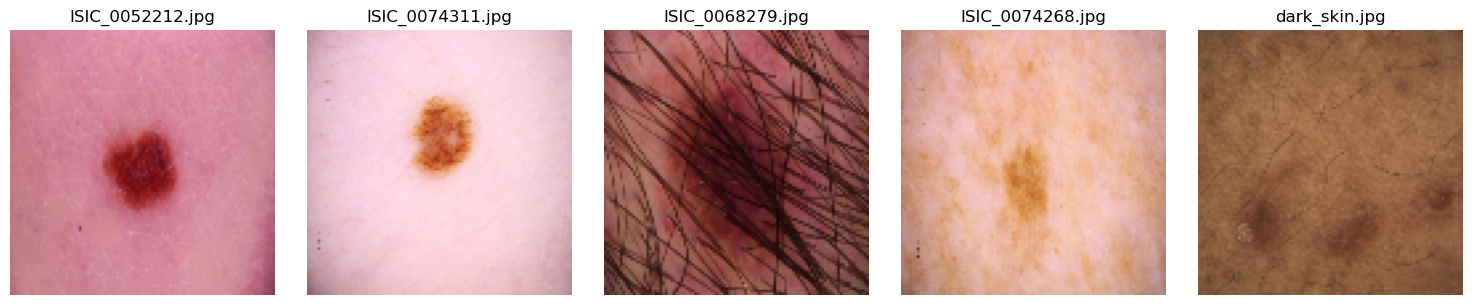

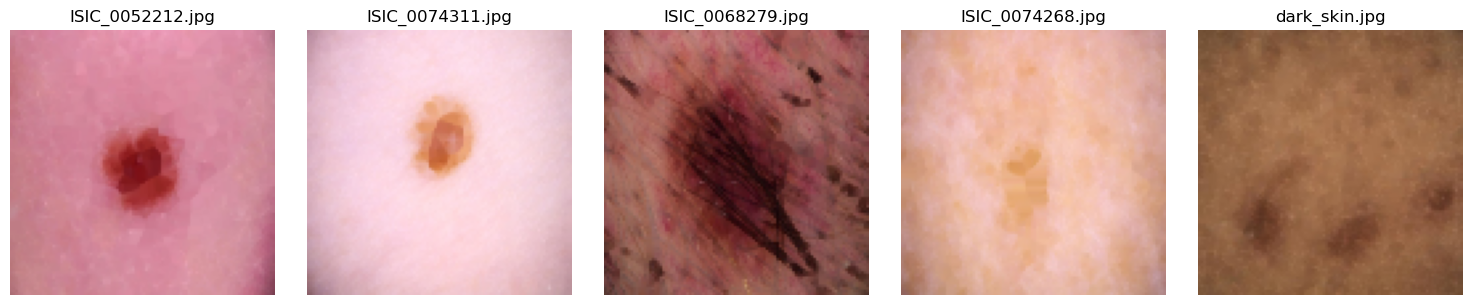

In [14]:
show_images_in_line(RESIZED_FOLDER)
show_images_in_line(OUTPUT_FOLDER)

# Conclusion